In [1]:
# src = https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y

In [3]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

In [4]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

In [5]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

In [6]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [7]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encodeing of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

In [8]:
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

Cost after epoch 0: 2.552061067946579
Cost after epoch 10: 2.551732786388436
Cost after epoch 20: 2.551389175364193
Cost after epoch 30: 2.55101179766319
Cost after epoch 40: 2.550582025759938
Cost after epoch 50: 2.5500798932707243
Cost after epoch 60: 2.549495253192336
Cost after epoch 70: 2.548798458457458
Cost after epoch 80: 2.547962966259529
Cost after epoch 90: 2.5469600675907387
Cost after epoch 100: 2.5457572256138064
Cost after epoch 110: 2.5443456307561343
Cost after epoch 120: 2.5426695787687517
Cost after epoch 130: 2.5406818548633407
Cost after epoch 140: 2.5383323154369393
Cost after epoch 150: 2.535564997115017
Cost after epoch 160: 2.5323809658906975
Cost after epoch 170: 2.528678881278582
Cost after epoch 180: 2.524385316998
Cost after epoch 190: 2.5194302234990418
Cost after epoch 200: 2.5137434858431336
Cost after epoch 210: 2.507382468633184
Cost after epoch 220: 2.50021255050232
Cost after epoch 230: 2.492181537327389
Cost after epoch 240: 2.483270991679638
Cost a

Cost after epoch 2630: 2.043867631819326
Cost after epoch 2640: 2.043916305709148
Cost after epoch 2650: 2.043965003132503
Cost after epoch 2660: 2.0440128113707696
Cost after epoch 2670: 2.044060404469865
Cost after epoch 2680: 2.0441077991798964
Cost after epoch 2690: 2.044154918379754
Cost after epoch 2700: 2.0442016840929487
Cost after epoch 2710: 2.044247223863899
Cost after epoch 2720: 2.044292184924065
Cost after epoch 2730: 2.0443365785926706
Cost after epoch 2740: 2.0443803271529974
Cost after epoch 2750: 2.0444233528056563
Cost after epoch 2760: 2.0444648598836634
Cost after epoch 2770: 2.044505443592768
Cost after epoch 2780: 2.0445451100296177
Cost after epoch 2790: 2.044583784605934
Cost after epoch 2800: 2.0446213933149258
Cost after epoch 2810: 2.0446572502060083
Cost after epoch 2820: 2.044691874361707
Cost after epoch 2830: 2.044725266376055
Cost after epoch 2840: 2.0447573577175904
Cost after epoch 2850: 2.0447880809693855
Cost after epoch 2860: 2.0448168878783233
Cos

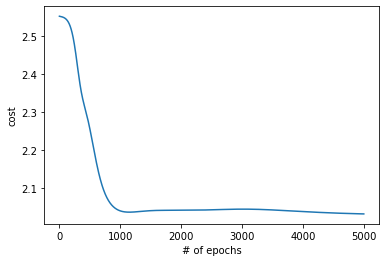

In [9]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

In [10]:
print(paras)

{'WRD_EMB': array([[-1.87783423e+00,  4.62530941e-01, -7.84737391e-01,
        -8.78867603e-01, -1.34677166e+00, -3.37294464e-01,
        -1.15106260e+00,  2.38445586e+00, -1.77079669e-01,
         1.18220478e+00, -9.42419376e-02,  1.31205038e+00,
        -1.73772917e+00, -2.07478319e+00, -1.32138585e+00,
         1.23090313e-01, -7.57503933e-02,  2.24795717e+00,
        -1.43525622e+00, -1.54340796e+00,  1.33887242e-01,
        -8.45375846e-01, -2.21792823e+00, -5.52419788e-01,
        -1.58479526e+00,  2.44422651e+00, -1.64060305e+00,
         3.95344517e-01, -1.56103327e+00,  1.89059551e+00,
        -7.38156110e-01, -7.03401724e-01, -8.10970505e-02,
        -3.06731636e+00, -1.24310941e+00,  5.80428800e-01,
         2.60524531e-01,  7.77173259e-01,  3.39348598e+00,
        -2.92041238e+00,  8.41672708e-01,  4.38953274e-01,
        -1.26300974e+00,  4.63065858e-01,  3.72441695e-01,
         1.41090473e+00, -2.22778912e+00, -1.36784570e+00,
         6.68402483e-01,  1.42397217e-01],
 

In [13]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [14]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

game's neighbor words: ['is', "loser's", 'a', 'beating']
of's neighbor words: ['the', 'of', 'costs', 'beating']
a's neighbor words: ['game', 'market', "loser's", 'stock']
is's neighbor words: ['game', 'market', "loser's", 'stock']
deduction's neighbor words: ['costs', 'after', 'the', 'beating']
investing's neighbor words: ['the', 'stock', 'beating', 'costs']
stock's neighbor words: ['investing', 'a', 'is', 'beating']
loser's's neighbor words: ['game', 'market', "loser's", 'stock']
beating's neighbor words: ['market', 'stock', 'investing', 'costs']
the's neighbor words: ['is', 'of', 'beating', 'stock']
after's neighbor words: ['of', 'the', 'deduction', 'costs']
market's neighbor words: ['is', "loser's", 'a', 'beating']
costs's neighbor words: ['beating', 'of', 'deduction', 'the']


In [19]:
print(vocab_size)
for input_ind in range(vocab_size):
    print(id_to_word[input_ind])

13
game
of
a
is
deduction
investing
stock
loser's
beating
the
after
market
costs


In [27]:
print(tokens)
print(word_to_id['after'])
print(len(Y_one_hot))
print(Y_one_hot[0])
print(X[0])

['after', 'the', 'deduction', 'of', 'the', 'costs', 'of', 'investing', 'beating', 'the', 'stock', 'market', 'is', 'a', "loser's", 'game']
10
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
[10 10 10  9  9  9  9  4  4  4  4  4  1  1  1  1  1  1  9  9  9  9  9  9
 12 12 12 12 12 12  1  1  1  1  1  1  5  5  5  5  5  5  8  8  8  8  8  8
  9  9  9  9  9  9  6  6  6  6  6  6 11 11 11 11 11 11  3  3  3  3  3  3
  2  2  2  2  2  7  7  7  7  0  0  0]


In [35]:
def getVector(word):
    id = word_to_id[word]
    return paras['WRD_EMB'][id]

In [36]:
print(getVector('after'))

[ 3.09989589 -1.24760072 -2.12867729  2.21345209  2.11769741 -0.98558531
  0.02210503 -1.29930619  1.05429827 -2.11985627  1.09252633 -0.30581258
  2.64334805  0.08955629  2.00655024  0.05115762  0.21918988 -0.24515171
  1.97845865 -1.68051762  0.69676039  3.92341023  1.0966616  -0.15610111
  0.49822441 -1.84230492  1.93600977  1.58210193  0.66887792 -1.2134437
  3.20583808  0.25795566  0.11216054  2.78917513  1.51499012 -1.45699886
  2.54909657 -1.74893669 -2.0167473   3.62099314  1.53767148  0.971594
  1.25608235  0.10967289 -0.81622802 -0.10258918  2.65564646  0.1772095
 -2.14962783  0.5060694 ]


In [39]:
word_vectors = {}
for word_id in id_to_word:
    word_vectors[id_to_word[word_id]] = paras['WRD_EMB'][word_id]
print(word_vectors)

{'game': array([-1.87783423,  0.46253094, -0.78473739, -0.8788676 , -1.34677166,
       -0.33729446, -1.1510626 ,  2.38445586, -0.17707967,  1.18220478,
       -0.09424194,  1.31205038, -1.73772917, -2.07478319, -1.32138585,
        0.12309031, -0.07575039,  2.24795717, -1.43525622, -1.54340796,
        0.13388724, -0.84537585, -2.21792823, -0.55241979, -1.58479526,
        2.44422651, -1.64060305,  0.39534452, -1.56103327,  1.89059551,
       -0.73815611, -0.70340172, -0.08109705, -3.06731636, -1.24310941,
        0.5804288 ,  0.26052453,  0.77717326,  3.39348598, -2.92041238,
        0.84167271,  0.43895327, -1.26300974,  0.46306586,  0.3724417 ,
        1.41090473, -2.22778912, -1.3678457 ,  0.66840248,  0.14239722]), 'of': array([-0.84598078,  2.85918148, -1.25874729,  2.91115822,  1.29434947,
       -2.88796145,  4.02864854, -1.08559295,  1.65977767, -2.83284335,
        0.78665028,  1.38365728,  3.57386936,  1.25689948, -1.89497055,
        0.52138474, -1.07141371, -1.74644349,  

In [42]:
print(X)
print(Y)
print(Y_one_hot)

[[10 10 10  9  9  9  9  4  4  4  4  4  1  1  1  1  1  1  9  9  9  9  9  9
  12 12 12 12 12 12  1  1  1  1  1  1  5  5  5  5  5  5  8  8  8  8  8  8
   9  9  9  9  9  9  6  6  6  6  6  6 11 11 11 11 11 11  3  3  3  3  3  3
   2  2  2  2  2  7  7  7  7  0  0  0]]
[[ 9  4  1 10  4  1  9 10  9  1  9 12 10  9  4  9 12  1  9  4  1 12  1  5
   4  1  9  1  5  8  1  9 12  5  8  9  9 12  1  8  9  6 12  1  5  9  6 11
   1  5  8  6 11  3  5  8  9 11  3  2  8  9  6  3  2  7  9  6 11  2  7  0
   6 11  3  7  0 11  3  2  0  3  2  7]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
path = 'companies.csv'

In [43]:
tickers = df['ticker']
data = []

for ticker in tickers:
    row = df[[ticker]]
    data.append([row['industry'],row['sector'],row['tag 1'],row['tag 2'],row['tag 3']])

NameError: name 'df' is not defined

In [ ]:
paras = skipgram_model_training(tickers, data, len(tickers), 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)